In [1]:
import pandas as pd
import os
import sys
import torch
import pickle
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from torch.nn import functional as F
import tqdm
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer

In [2]:
tokenizers_root = r"/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/data"
out_root = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump'

data_folder = r'babylm_full_bpe_8k'
model_name = 'out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337'

out_dir = os.path.join(out_root, model_name)
data_dir = os.path.join(tokenizers_root, data_folder)

device = "cuda"

In [21]:
def load_model(out_dir, device):
    """
    Loads a pre-trained GPT model from a checkpoint file.

    Args:
        out_dir (str): The directory where the checkpoint file is located.
        device (torch.device): The device to load the model onto.

    Returns:
        GPT: The loaded GPT model.

    Raises:
        FileNotFoundError: If the checkpoint file is not found.
    """
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    print(f"Loading model from {ckpt_path}")
    #NANOGPT_ROOT = str(Path(__file__).parents[4])
    NANOGPT_ROOT = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT' #Edit later to be dynamic
    sys.path.append(NANOGPT_ROOT)
    from model import GPT, GPTConfig

    checkpoint = torch.load(ckpt_path, map_location=device)

    # Backward compatibility for new model args for QKV and FFW Adjustments
    if checkpoint["model_args"].get("wm_decay_length", None) is None:
        #wm_decay_length = block_size
        checkpoint["model_args"]["wm_decay_length"] = checkpoint["model_args"]["block_size"]
    # Setting head size as 3 times n_embd if not set already
    if checkpoint['model_args'].get('head_size_qkv', None) is None:
        checkpoint['model_args']['head_size_qkv'] = checkpoint['model_args']['n_embd']

    if checkpoint["model_args"].get("ffw_dim", None) is None:
        checkpoint["model_args"]["ffw_dim"] = 4 * checkpoint["model_args"]["n_embd"]

    #print(checkpoint['model_args'])
    gptconf = GPTConfig(**checkpoint['model_args'])

    load_model = GPT(gptconf)

    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

    load_model.load_state_dict(state_dict)
    load_model.eval()

    load_model = load_model.to(device)

    return load_model

def load_tokenizer(data_dir):
    """
    Load tokenizer for natural stories evaluation.

    Args:
        data_dir (str): The directory path where the tokenizer data is stored.

    Returns:
        tokenizer (Tokenizer): The loaded tokenizer object.

    Raises:
        NotImplementedError: If stoi/itos is not supported or found.

    """
    meta_path = os.path.join(data_dir, 'meta.pkl')
    load_meta = os.path.exists(meta_path)
    if load_meta:
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        if meta.get("custom_tokenizer", False):
            print(f"Loading custom tokenizer from {data_dir}")
            tokenizer = AutoTokenizer.from_pretrained(data_dir, use_fast=False)
        else:
            if meta.get("stoi", False):
                raise NotImplementedError("stoi/itos not supported yet")
            else:
                raise NotImplementedError("No stoi/itos found")
    else:
        print("No meta.pkl found, using default GPT-2 tokenizer")
        tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

    if not tokenizer.eos_token:
        tokenizer.add_special_tokens({"eos_token": "</s>"})
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    tokenizer.padding_side = "left" #Add if needed?
    return tokenizer

def load_model_tokenizer(out_dir, data_dir, device):
    model = load_model(out_dir, device)
    tokenizer = load_tokenizer(data_dir)
    return model, tokenizer


In [22]:
model, tokenizer = load_model_tokenizer(out_dir, data_dir, device)


Loading model from /home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump/out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337/ckpt.pt
Setting flash to False because wm_mask is enabled
Setting flash to False because wm_mask is enabled
Setting flash to False because wm_mask is enabled
Setting flash to False because wm_mask is enabled
Setting flash to False because wm_mask is enabled
Setting flash to False because wm_mask is enabled
number of parameters: 13.69M
Loading custom tokenizer from /home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/data/babylm_full_bpe_8k


In [23]:
processsed_RTs = pd.read_csv(r'naturalstories_RTS/processed_RTs.tsv', sep='\t')
#column Item represents the story number, zone is word analogue to word number in the story. Sort by Item and Zone to get the word order in the story
processsed_RTs = processsed_RTs.sort_values(by=['item', 'WorkerId', 'zone'])

processed_wordinfo = pd.read_csv(r'naturalstories_RTS/processed_wordinfo.tsv', sep='\t')
processed_wordinfo = processed_wordinfo.sort_values(by=['item', 'zone'])

all_stories = pd.read_csv(r'naturalstories_RTS/all_stories.tok', sep='\t')
all_stories = all_stories.sort_values(by=['item', 'zone'])

In [24]:
#A bit of EDA
#Number of words in each story
print(all_stories.groupby('item').size())


item
1     1073
2      990
3     1040
4     1085
5     1013
6     1099
7      999
8      980
9     1038
10     939
dtype: int64


In [25]:
def extract_stories_from_df(stories_df):
    """
    Extract stories from the dataframe with id as key and story as value
    :param stories_df: 
    :return: stories: Dictionary with story id as key and story as value
    """
    stories = {}
    story_ids = stories_df["item"].unique()
    for story_id in story_ids:
        story = stories_df[stories_df["item"] == story_id]
        story_text = story.sort_values(by=['zone'])['word'].str.cat(sep=' ')
        stories[story_id] = story_text

    return stories

stories_list = extract_stories_from_df(processed_wordinfo)

In [26]:
#Find better ways to write this function
def verify_stories_list(stories_list):
    master_stories_xlsx_path = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/repl_repos/naturalstories/parsed-natural-stories.xlsx'
    sheet_to_item_map = {1:"Boar", 2:"Aqua", 3:"Matchstick", 4:"King of Birds", 5:"Elvis", 6:"Mr Sticky", 7:"High School", 8:"Roswell", 9:"Tulips", 10:"Tourette"}
    sheet_to_item_map_inv = {v: k for k, v in sheet_to_item_map.items()}

    for item in stories_list:
        #Read_specific sheet
        item_sheet = pd.read_excel(master_stories_xlsx_path, sheet_name=sheet_to_item_map[item])
        item_story = item_sheet['Sentence'].str.cat(sep=' ')

        if item_story != stories_list[item]:
            print(f"Story {item} does not match")

            #Check word by word
            item_story_words = item_story.split()
            item_story_words = [word.lower() for word in item_story_words]
            original_story_words = stories_list[item].split()
            original_story_words = [word.lower() for word in original_story_words]

            for i in range(len(item_story_words)):
                if item_story_words[i] != original_story_words[i]:
                    print(f"Word {i} does not match")
                    print(f"Original: {original_story_words[i]}")
                    print(f"Item: {item_story_words[i]}")
                    break
        else:
            print(f"Story {item} matches")


In [27]:
def tokenize_story(story, tokenizer):
    tokenized_story = tokenizer.encode(story, return_tensors='pt')
    #since passing only one story, remove the batch dimension
    tokenized_story = tokenized_story.squeeze()
    return tokenized_story

def multitoken_wordmap(token_list, story_id, story_df):

    word_list = story_df[story_df['item'] == story_id][['word', 'zone']].to_dict('records')
    word_list = sorted(word_list, key=lambda x: x['zone'])

    token_map = []
    token_index = 0
    for i, word_row in enumerate(word_list):
        word = word_row['word']
        zone = word_row['zone']
        #since 1 word can be multiple tokens, we need to keep track of the tokens that make up the word
        decode_list = []
        while True:
            if token_index >= len(token_list):
                break
            decode_list.append(token_list[token_index].item())
            decoded_words = tokenizer.decode(decode_list).strip()
            token_index += 1
            if word.lower() == decoded_words:
                break

        token_map.append({"item": story_id, "zone": zone, "word": word, "tokens": decode_list})
    return token_map

token_map_df = pd.DataFrame(columns=['item', 'zone', 'word', 'tokens'])
for i, story in stories_list.items():
    tokenized_story_i = tokenize_story(story, tokenizer)
    token_map = multitoken_wordmap(tokenized_story_i, i, processed_wordinfo)
    token_map_df = pd.concat([token_map_df, pd.DataFrame(token_map)])


In [28]:
def return_surprisals(model, token_list):
    if len(token_list)>model.config.block_size:
        token_list = token_list[-model.config.block_size:]
    token_tensor = torch.tensor(token_list).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(token_tensor[:, :-1], token_tensor[:, 1:])
    probs = F.log_softmax(logits, dim=-1)
    token_logprob = probs[0, -1, token_tensor[0, -1]].item()
    return -token_logprob

def get_model_surprisals(model, tokenized_story_df, story_id):
    tokenized_story = tokenized_story_df[tokenized_story_df['item'] == story_id].to_dict('records')
    tokenized_story = sorted(tokenized_story, key=lambda x: x['zone'])
    #Prepend the bos token
    logits_input_list = [tokenizer.bos_token_id]

    for word_row in tqdm.tqdm(tokenized_story):
        tokens = word_row['tokens']
        if len(tokens) == 1:
            logits_input_list.append(tokens[0])
            word_surprisal = return_surprisals(model, logits_input_list)
        else:
            word_surprisal = 0
            for token in tokens:
                logits_input_list.append(token)
                word_surprisal += return_surprisals(model, logits_input_list)

        word_row['surprisal'] = word_surprisal

    return tokenized_story

story_surprisals_df = pd.DataFrame()
for i, story in stories_list.items():
    print(f"Processing story {i}")
    story_surprisals = get_model_surprisals(model, token_map_df, i)
    story_surprisals_df = pd.concat([story_surprisals_df, pd.DataFrame(story_surprisals)])



Processing story 1


100%|██████████| 1073/1073 [00:09<00:00, 108.43it/s]


Processing story 2


100%|██████████| 990/990 [00:08<00:00, 121.37it/s]


Processing story 3


100%|██████████| 1040/1040 [00:07<00:00, 130.52it/s]


Processing story 4


100%|██████████| 1085/1085 [00:08<00:00, 127.56it/s]


Processing story 5


100%|██████████| 1013/1013 [00:07<00:00, 131.29it/s]


Processing story 6


100%|██████████| 1099/1099 [00:09<00:00, 119.44it/s]


Processing story 7


100%|██████████| 999/999 [00:07<00:00, 129.09it/s]


Processing story 8


100%|██████████| 980/980 [00:09<00:00, 107.54it/s]


Processing story 9


100%|██████████| 1038/1038 [00:09<00:00, 109.50it/s]


Processing story 10


100%|██████████| 939/939 [00:08<00:00, 107.08it/s]


In [11]:
processsed_RTs = pd.read_csv(r'naturalstories_RTS/processed_RTs.tsv', sep='\t')
#column Item represents the story number, zone is word analogue to word number in the story. Sort by Item and Zone to get the word order in the story
processsed_RTs = processsed_RTs.sort_values(by=['item', 'WorkerId', 'zone'])

processed_wordinfo = pd.read_csv(r'naturalstories_RTS/processed_wordinfo.tsv', sep='\t')
processed_wordinfo = processed_wordinfo.sort_values(by=['item', 'zone'])

all_stories = pd.read_csv(r'naturalstories_RTS/all_stories.tok', sep='\t')
all_stories = all_stories.sort_values(by=['item', 'zone'])

In [12]:


#Join the surprisals with the original wordinfo and RTs

print(f"Original RTs shape: {processsed_RTs.shape}")
processsed_RTs = processsed_RTs.merge(story_surprisals_df, on=['item', 'zone', 'word'], how='left')
print(f"Processed RTs shape: {processsed_RTs.shape}")

print(f"Original wordinfo shape: {processed_wordinfo.shape}")
processed_wordinfo = processed_wordinfo.merge(story_surprisals_df, on=['item', 'zone', 'word'], how='left')
print(f"Processed wordinfo shape: {processed_wordinfo.shape}")

#Add addition columns for the surprisals of the previous 2 words but for in each worker, story separately
processsed_RTs['surprisal_lag_1'] = processsed_RTs.groupby(['item', 'WorkerId'])['surprisal'].shift(1)
processsed_RTs['surprisal_lag_2'] = processsed_RTs.groupby(['item', 'WorkerId'])['surprisal'].shift(2)

processed_wordinfo['surprisal_lag_1'] = processed_wordinfo.groupby(['item'])['surprisal'].shift(1)
processed_wordinfo['surprisal_lag_2'] = processed_wordinfo.groupby(['item'])['surprisal'].shift(2)


#Fill NaN values with different strategies
#Option 1 - Mean/Median of first word surprisal across stories -group by zone
#Option 2 - Mean/Median of all surprisals in a story - group by item


processsed_RTs["surprisal_lag_1"] = processsed_RTs['surprisal_lag_1'].fillna(processsed_RTs.groupby(['item'])['surprisal'].transform('mean'))
processsed_RTs['surprisal_lag_2'] = processsed_RTs['surprisal_lag_2'].fillna(processsed_RTs.groupby(['item'])['surprisal'].transform('mean'))

processed_wordinfo["surprisal_lag_1"] = processed_wordinfo['surprisal_lag_1'].fillna(processsed_RTs.groupby(['item'])['surprisal'].transform('mean'))
processed_wordinfo['surprisal_lag_2'] = processed_wordinfo['surprisal_lag_2'].fillna(processsed_RTs.groupby(['item'])['surprisal'].transform('mean'))


Original RTs shape: (848767, 12)
Processed RTs shape: (848767, 14)
Original wordinfo shape: (10256, 8)
Processed wordinfo shape: (10256, 10)


In [13]:
processsed_RTs

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,tokens,surprisal,surprisal_lag_1,surprisal_lag_2
0,A117RW2F1MNBQ8,2792,6,1,1,360,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,5.135173,5.135173
1,A117RW2F1MNBQ8,2792,6,1,2,304,you,87,368.183908,168.027166,339.746188,1.475379,[208],4.996484,10.754425,5.135173
2,A117RW2F1MNBQ8,2792,6,1,3,270,were,88,344.318182,224.916666,310.337960,1.505613,[394],3.633209,4.996484,10.754425
3,A117RW2F1MNBQ8,2792,6,1,4,292,to,86,354.639535,310.065644,305.686701,1.603190,[196],1.931369,3.633209,4.996484
4,A117RW2F1MNBQ8,2792,6,1,5,304,journey,89,349.674157,198.212855,315.986066,1.530090,[4751],10.880624,1.931369,3.633209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848762,AZACM8ZW3MN8N,1011,5,10,42,2945,early,73,456.410959,472.287014,370.669160,1.710397,[1684],6.824074,7.045103,1.764608
848763,AZACM8ZW3MN8N,1011,5,10,43,498,symptoms,74,349.554054,124.645485,330.514601,1.393858,[6893],4.735064,6.824074,7.045103
848764,AZACM8ZW3MN8N,1011,5,10,937,253,treatments,72,359.861111,107.835595,342.418649,1.388847,"[2113, 1309]",10.339849,4.735064,6.824074
848765,AZACM8ZW3MN8N,1011,5,10,938,236,for,70,506.728571,339.573770,437.976093,1.664676,[248],3.227745,10.339849,4.735064


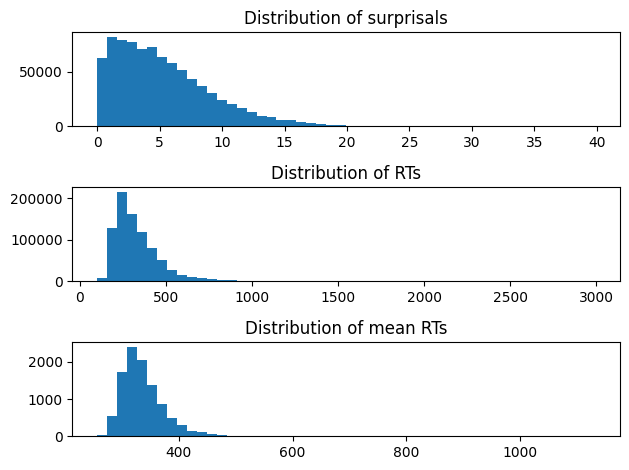

In [14]:
#Quick EDAs
#Show all plots as subplots

#MAke 3 histograms as subplots
fig, axs = plt.subplots(3)
#fig.suptitle('Surprisal distributions')

#Plot the distribution of surprisals
axs[0].hist(processsed_RTs['surprisal'], bins=50)
#Add title to the subplot
axs[0].set_title("Distribution of surprisals")

#Plot the distribution of RTs
axs[1].hist(processsed_RTs['RT'], bins=50)
axs[1].set_title("Distribution of RTs")

#Plot distribution of mean RTs
axs[2].hist(processed_wordinfo['meanItemRT'], bins=50)
axs[2].set_title("Distribution of mean RTs")
#Increase the space between the subplots
plt.tight_layout()


plt.show()


In [27]:
#build linear model to predict RTs from surprisals

def build_linear_model(data_df, x_type = "surprisal", per_subject=False, subject_id=None):
    """
    Build a linear model to predict RTs from surprisals

    Assuming data_df is the right df being passed. If per subject, it needs to be processed_RTs, else processed_wordinfo
    :param data_df: Dataframe containing the RTs and surprisals, if per_subject is True, then the dataframe should contain WorkerId.
    :param x_type: Choice between only surprisal, or 1 lag or 2 lag, can be surprisal, lag 1, lag 2
    :param per_subject: If True, then the model will be built per subject. If False, then the model will be built for all subjects, on mean RTs
    :param subject_id: If per_subject is True, then the subject_id should be provided to build the model for that subject
    :return: regr: The linear regression model, mse: Mean squared error, r2: R squared value, X_train, X_test, y_train, y_test
    :return:
    """

    if per_subject:
        if subject_id is None:
            raise ValueError("subject_id should be provided if per_subject is True")
        data_df = data_df[data_df['WorkerId'] == subject_id]

    if x_type == "surprisal":
        X = data_df[['surprisal']].to_numpy()
    elif x_type == "lag 1":
        X = data_df[["surprisal", 'surprisal_lag_1']].to_numpy()
    elif x_type == "lag 2":
        X = data_df[['surprisal', 'surprisal_lag_1', 'surprisal_lag_2']].to_numpy()
    else:
        raise ValueError("Invalid x_type, should be surprisal, lag 1 or lag 2")

    if per_subject:
        y = data_df['RT'].to_numpy()
    else:
        y = data_df['meanItemRT'].to_numpy() #assuming the right df is passed

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #print("X_train shape, X_test shape, y_train shape, y_test shape", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)

    #print('Intercept: \n', regr.intercept_)
    #print('Coefficients: \n', regr.coef_)

    #calculate the mean squared error
    mse = np.mean((regr.predict(X_test) - y_test) ** 2)
    #print(f"Mean squared error: {mse}")

    #Calculate the R squared value
    r2 = regr.score(X_test, y_test)
    #print(f"R squared value: {r2}")

    #Predict RTs for the train and test to calculate the correlation coefficient later
    y_train_predicted = regr.predict(X_train)
    y_test_predicted = regr.predict(X_test)

    #calculate the correlation coefficient
    corr_train = np.corrcoef(y_train, y_train_predicted)
    corr_test = np.corrcoef(y_test, y_test_predicted)

    return regr, mse, r2, X_train, X_test, y_train, y_test, y_train_predicted, y_test_predicted, corr_train, corr_test


def build_linear_model_kfold(data_df, x_type = "surprisal", per_subject=False, subject_id=None):
    """
    Build a kfold crossvalidation linear model to predict RTs from surprisals

    Assuming data_df is the right df being passed. If per subject, it needs to be processed_RTs, else processed_wordinfo
    :param data_df: Dataframe containing the RTs and surprisals, if per_subject is True, then the dataframe should contain WorkerId.
    :param x_type: Choice between only surprisal, or 1 lag or 2 lag, can be surprisal, lag 1, lag 2
    :param per_subject: If True, then the model will be built per subject. If False, then the model will be built for all subjects, on mean RTs
    :param subject_id: If per_subject is True, then the subject_id should be provided to build the model for that subject
    :return: regr: The linear regression model, mse: Mean squared error, r2: R squared value, X_train, X_test, y_train, y_test
    :return:
    """

    if per_subject:
        if subject_id is None:
            raise ValueError("subject_id should be provided if per_subject is True")
        data_df = data_df[data_df['WorkerId'] == subject_id]

    if x_type == "surprisal":
        X = data_df[['surprisal']].to_numpy()
    elif x_type == "lag 1":
        X = data_df[["surprisal", 'surprisal_lag_1']].to_numpy()
    elif x_type == "lag 2":
        X = data_df[['surprisal', 'surprisal_lag_1', 'surprisal_lag_2']].to_numpy()
    else:
        raise ValueError("Invalid x_type, should be surprisal, lag 1 or lag 2")

    if per_subject:
        y = data_df['RT'].to_numpy()
    else:
        y = data_df['meanItemRT'].to_numpy() #assuming the right df is passed

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    def custom_correlation_coeff_scorer(y_true, y_pred):
        return np.corrcoef(y_true, y_pred)[0][1]
    #print("X_train shape, X_test shape, y_train shape, y_test shape", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    regr = linear_model.LinearRegression()
    #regr.fit(X_train, y_train)
    scores = cross_validate(regr, X, y, cv=5, scoring={'r2': 'r2', 
                                                       'neg_mean_squared_error': 'neg_mean_squared_error', 
                                                       'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                                                       "explained_variance": "explained_variance",
                                                       "custom_correlation_coeff_scorer": make_scorer(custom_correlation_coeff_scorer)}, 
                            return_train_score=True)    
    return scores



def all_subject_summary_train_test(processed_RTs):

    subject_id_list = processed_RTs['WorkerId'].unique()

    ytrain_list = []
    ytest_list = []
    ytrain_pred_list = []
    ytest_pred_list = []
    #corr_train_list = []
    #corr_test_list = []
    subject_summary = []

    for subject_id in tqdm.tqdm(subject_id_list):

        #ignore the subject if the number of data points is less than 1000 (assuming 1 story has atleast 1000 data points)

        if len(processed_RTs[processed_RTs['WorkerId'] == subject_id]) < 1000:
            continue

        regre_surprisal, mse_surprisal, r2_surprisal, X_train_surprisal, X_test_surprisal, y_train_surprisal, y_test_surprisal, y_train_pred_surprisal, y_test_pred_surprisal, corr_train_surprisal, corr_test_surprisal = build_linear_model(processsed_RTs, x_type="lag 2", per_subject=True, subject_id=subject_id)

        ytrain_list.append(y_train_surprisal)
        ytest_list.append(y_test_surprisal)
        ytrain_pred_list.append(y_train_pred_surprisal)
        ytest_pred_list.append(y_test_pred_surprisal)

        #corr_train_list.append(corr_train_surprisal)
        #corr_test_list.append(corr_test_surprisal)
        subject_summary.append({"subject_id": subject_id,
                                "data_points": len(X_train_surprisal) + len(X_test_surprisal),
                                "mse_surprisal": mse_surprisal,
                                "r2_surprisal": r2_surprisal,
                                "corr_train_surprisal": corr_train_surprisal[0][1],
                                "corr_test_surprisal": corr_test_surprisal[0][1]})

    y_train = np.concatenate(ytrain_list)
    y_test = np.concatenate(ytest_list)
    y_train_pred = np.concatenate(ytrain_pred_list)
    y_test_pred = np.concatenate(ytest_pred_list)

    #Calculate the correlation coefficient

    corr_train = np.corrcoef(y_train, y_train_pred)
    corr_test = np.corrcoef(y_test, y_test_pred)

    print(f"Correlation coefficient for train: {corr_train}")
    print(f"Correlation coefficient for test: {corr_test}")

    #Average the correlation coefficients
    #corr_train = np.mean(corr_train_list)
    #corr_test = np.mean(corr_test_list)

    return corr_train, corr_test, pd.DataFrame(subject_summary)


def all_subject_summary_kfold(processed_RTs):

    subject_id_list = processed_RTs['WorkerId'].unique()

    subject_summary = []

    for subject_id in tqdm.tqdm(subject_id_list):

        #ignore the subject if the number of data points is less than 1000 (assuming 1 story has atleast 1000 data points)

        if len(processed_RTs[processed_RTs['WorkerId'] == subject_id]) < 1000:
            continue

        scores = build_linear_model_kfold(processsed_RTs, x_type="lag 2", per_subject=True, subject_id=subject_id)
        
        subject_summary.append({"subject_id": subject_id,
                                "data_points": len(processed_RTs[processed_RTs['WorkerId'] == subject_id]),
                                "mse_surprisal": -1*np.mean(scores['test_neg_mean_squared_error']),   
                                "rmse_surprisal": -1*np.mean(scores['test_neg_root_mean_squared_error']),
                                "r2_surprisal": np.mean(scores['test_r2']),
                                "explained_variance": np.mean(scores['test_explained_variance']),
                                "corr_surprisal": np.mean(scores['test_custom_correlation_coeff_scorer'])})
        

    return pd.DataFrame(subject_summary)


def plot_linear_model(X, y, regr):
    plt.scatter(X, y)
    plt.plot(X, regr.predict(X), color='red')
    plt.show()


In [28]:
scores_df = all_subject_summary_kfold(processsed_RTs)

scores_df


100%|██████████| 180/180 [00:27<00:00,  6.60it/s]


,subject_id,data_points,mse_surprisal,rmse_surprisal,r2_surprisal,explained_variance,corr_surprisal
0,A117RW2F1MNBQ8,5198,11777.330893,102.849329,-1.380647,0.004710,0.147227
1,A11AUVZ4MCA7VU,10224,30296.185302,173.348525,0.018231,0.023230,0.155763
2,A11GA4B4SEYK44,4211,11209.816511,97.491961,-0.065658,0.026805,0.168679
3,A11KMPAZSE5Q0Q,5199,3954.970703,62.090493,-0.043140,0.002080,0.057569
4,A127R5QI5OGBIK,5194,18325.622094,132.878420,-0.737667,0.017471,0.133256
...,...,...,...,...,...,...,...
159,ASOBUAZ0IQYSJ,4115,26605.817173,159.395763,-0.025567,0.027983,0.177018
160,AVG2BI8CS5YKX,5033,15808.714349,123.973948,-0.322605,0.017154,0.138357
161,AWMGC78CSF6YL,3958,18027.960591,131.407724,0.010954,0.023184,0.158779
162,AWZ3AH7JH0DRO,5033,34862.006578,180.885724,-0.093829,0.014281,0.122978


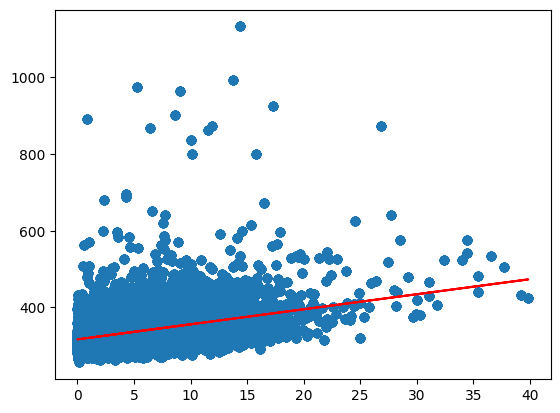

In [32]:
#Build the linear model for surprisal only
regr, mse, r2, X_train, X_test, y_train, y_test,_, _, _,_ = build_linear_model(processsed_RTs, x_type="surprisal", per_subject=False)
plot_linear_model(X_test, y_test, regr)


#Build the linear model for surprisal and lag 2
regr_lag2, mse_lag2, r2_lag2, X_train_lag2, X_test_lag2, y_train_lag2, y_test_lag2,_,_, _, _ = build_linear_model(processsed_RTs, x_type="lag 2", per_subject=False)


Building model for subject A2VG5S4UL5UGRS


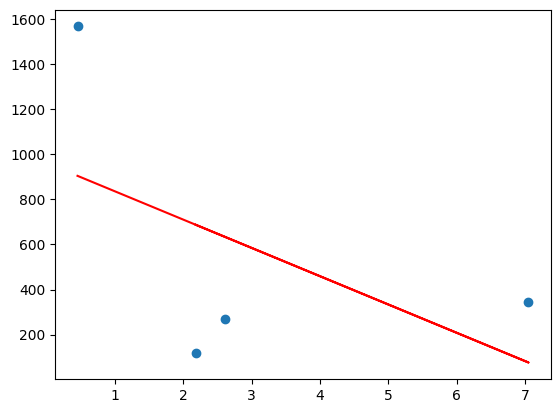

Mean squared error: 162648.73355128712
R squared value: -320.2814489901968
Correlation coefficient for train: [[1.         0.52820096]
 [0.52820096 1.        ]]
Correlation coefficient for test: [[1. 1.]
 [1. 1.]]
KK [[3.15218186]
 [3.77172828]] 
 
  [146 101] 
 
 [565.28861062 487.64522254]
[[0.44957599]
 [2.61112595]
 [7.05032301]
 [2.1797595 ]] 
 [1566  271  344  120] 
 [[3.15218186]
 [3.77172828]] 
 [146 101]
Correlation coefficient for train: [[1. 1.]
 [1. 1.]]
Correlation coefficient for test: [[ 1. -1.]
 [-1.  1.]]


In [33]:
#Build the linear model for surprisal only for a specific subject
#randomly choose a subject from WorkerId
subject_id = processsed_RTs['WorkerId'].sample().iloc[0]
subject_id = "A2VG5S4UL5UGRS"
print(f"Building model for subject {subject_id}")

regr_subject, mse_subject, r2_subject, X_train_subject, X_test_subject, y_train_subject, y_test_subject, _,_, corr_train,corr_test = build_linear_model(processsed_RTs, x_type="surprisal", per_subject=True, subject_id=subject_id)
plot_linear_model(X_train_subject, y_train_subject, regr_subject)

print(f"Mean squared error: {mse_subject}")
print(f"R squared value: {r2_subject}")
print(f"Correlation coefficient for train: {corr_train}")
print(f"Correlation coefficient for test: {corr_test}")

print("KK", X_test_subject, "\n \n ", y_test_subject,"\n \n", regr_subject.predict(X_test_subject))

print(X_train_subject, "\n", y_train_subject, "\n", X_test_subject, "\n", y_test_subject)
#Build the linear model for surprisal and lag 2 for a specific subject
regr_lag2_subject, mse_lag2_subject, r2_lag2_subject, X_train_lag2_subject, X_test_lag2_subject, y_train_lag2_subject, y_test_lag2_subject, _,_, corr_train,corr_test = build_linear_model(processsed_RTs, x_type="lag 2", per_subject=True, subject_id=subject_id)

print(f"Correlation coefficient for train: {corr_train}")
print(f"Correlation coefficient for test: {corr_test}")

In [34]:
#Calculate the correlation coefficient for the subject
corr_train, corr_test, subject_summary = all_subject_summary(processsed_RTs)

subject_summary


100%|██████████| 180/180 [00:17<00:00, 10.43it/s]

Correlation coefficient for train: [[1.         0.50810683]
 [0.50810683 1.        ]]
Correlation coefficient for test: [[1.        0.5117991]
 [0.5117991 1.       ]]


,subject_id,data_points,mse_surprisal,r2_surprisal,corr_train_surprisal,corr_test_surprisal
0,A117RW2F1MNBQ8,5198,7001.596591,0.035822,0.104591,0.208141
1,A11AUVZ4MCA7VU,10224,21978.204660,0.017317,0.153972,0.145059
2,A11GA4B4SEYK44,4211,15078.856735,0.009261,0.176243,0.105772
3,A11KMPAZSE5Q0Q,5199,2535.997478,0.000110,0.072232,0.070435
4,A127R5QI5OGBIK,5194,12879.093620,0.009883,0.101728,0.108740
...,...,...,...,...,...,...
159,ASOBUAZ0IQYSJ,4115,30275.070604,0.030975,0.188483,0.179317
160,AVG2BI8CS5YKX,5033,12008.968026,0.009730,0.108903,0.099591
161,AWMGC78CSF6YL,3958,12727.749149,0.034211,0.145921,0.195896
162,AWZ3AH7JH0DRO,5033,34160.477597,0.001605,0.142978,0.073170


In [100]:
#FIlter for rows that contain NaN values in prev_surprisal_1 or 2 where the zone is not 1 or 2

filter_processed_rt_df = processsed_RTs[((processsed_RTs['zone'] != 1) & (processsed_RTs['zone'] != 2) & ((processsed_RTs['surprisal_lag_1'].isna()) | (processsed_RTs['surprisal_lag_2'].isna())))]
#For every triplet of WorkerId, item, zone count number of total tows from the original dataframe
#filter_processed_rt_df['total_rows'] = processsed_RTs.groupby(['WorkerId', 'item'])['zone'].transform('count')
filter_processed_rt_df

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,tokens,surprisal,surprisal_lag_1,surprisal_lag_2


In [97]:
processed_wordinfo

,word,zone,item,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,tokens,surprisal,surprisal_lag_1,surprisal_lag_2
0,If,1,1,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,5.135173,5.135173
1,you,2,1,87,368.183908,168.027166,339.746188,1.475379,[208],4.996484,10.754425,5.135173
2,were,3,1,88,344.318182,224.916666,310.337960,1.505613,[394],3.633209,4.996484,10.754425
3,to,4,1,86,354.639535,310.065644,305.686701,1.603190,[196],1.931369,3.633209,4.996484
4,journey,5,1,89,349.674157,198.212855,315.986066,1.530090,[4751],10.880624,1.931369,3.633209
...,...,...,...,...,...,...,...,...,...,...,...,...
10251,and,935,10,70,317.414286,112.983581,300.670987,1.380108,[207],1.465932,13.673204,8.604348
10252,better,936,10,71,335.267606,134.405353,312.120415,1.453014,[979],4.438877,1.465932,13.673204
10253,treatments,937,10,72,359.861111,107.835595,342.418649,1.388847,"[2113, 1309]",10.339849,4.438877,1.465932
10254,for,938,10,70,506.728571,339.573770,437.976093,1.664676,[248],3.227745,10.339849,4.438877


In [11]:
story_surprisals_df

,item,zone,word,tokens,surprisal
0,1,1,If,[333],10.754425
1,1,2,you,[208],4.996484
2,1,3,were,[394],3.633209
3,1,4,to,[196],1.931369
4,1,5,journey,[4751],10.880624
...,...,...,...,...,...
934,10,935,and,[207],1.465932
935,10,936,better,[979],4.438877
936,10,937,treatments,"[2113, 1309]",10.339849
937,10,938,for,[248],3.227745


In [12]:
token_map_df

,item,zone,word,tokens
0,1,1,If,[333]
1,1,2,you,[208]
2,1,3,were,[394]
3,1,4,to,[196]
4,1,5,journey,[4751]
...,...,...,...,...
934,10,935,and,[207]
935,10,936,better,[979]
936,10,937,treatments,"[2113, 1309]"
937,10,938,for,[248]


In [23]:
processed_wordinfo

,word,zone,item,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,tokens,surprisal
0,If,1,1,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425
1,you,2,1,87,368.183908,168.027166,339.746188,1.475379,[208],4.996484
2,were,3,1,88,344.318182,224.916666,310.337960,1.505613,[394],3.633209
3,to,4,1,86,354.639535,310.065644,305.686701,1.603190,[196],1.931369
4,journey,5,1,89,349.674157,198.212855,315.986066,1.530090,[4751],10.880624
...,...,...,...,...,...,...,...,...,...,...
10251,and,935,10,70,317.414286,112.983581,300.670987,1.380108,[207],1.465932
10252,better,936,10,71,335.267606,134.405353,312.120415,1.453014,[979],4.438877
10253,treatments,937,10,72,359.861111,107.835595,342.418649,1.388847,"[2113, 1309]",10.339849
10254,for,938,10,70,506.728571,339.573770,437.976093,1.664676,[248],3.227745


In [39]:
processsed_RTs

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT,tokens,surprisal,prev_surprisal_1,prev_surprisal_2
0,A3QJPB0NZU5PY1,3960,6,1,1,924,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,NaN,NaN
1,A2RPQGUWVZPX7U,2431,5,1,1,474,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,NaN,NaN
2,A11KMPAZSE5Q0Q,1287,5,1,1,272,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,NaN,NaN
3,A1U1QL617G5DU3,2074,6,1,1,354,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,NaN,NaN
4,ACTW5YEWV9OR0,2213,6,1,1,577,If,84,369.011905,160.579935,340.566023,1.490513,[333],10.754425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848762,A5U9HUMS31DIR,6071,6,10,939,1187,Tourette's.,62,991.129032,574.851670,861.407392,1.689601,"[1912, 1111, 482, 225, 14]",13.747851,3.227745,10.339849
848763,A253Q11TZPQPIZ,2001,6,10,939,800,Tourette's.,62,991.129032,574.851670,861.407392,1.689601,"[1912, 1111, 482, 225, 14]",13.747851,3.227745,10.339849
848764,A1WURYN1U64Y1T,1554,6,10,939,902,Tourette's.,62,991.129032,574.851670,861.407392,1.689601,"[1912, 1111, 482, 225, 14]",13.747851,3.227745,10.339849
848765,A1INWCFGQI236V,1569,6,10,939,576,Tourette's.,62,991.129032,574.851670,861.407392,1.689601,"[1912, 1111, 482, 225, 14]",13.747851,3.227745,10.339849


In [65]:
processsed_RTs[ processsed_RTs["WorkerId"]=="A2VG5S4UL5UGRS"]

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT
470923,A2VG5S4UL5UGRS,370,5,6,64,146,it,83,294.289157,91.169974,280.813143,1.361450
471173,A2VG5S4UL5UGRS,370,5,6,67,101,who,84,343.761905,303.425210,301.135574,1.554212
472162,A2VG5S4UL5UGRS,370,5,6,79,271,the,83,349.289157,212.077156,311.579446,1.563552
472410,A2VG5S4UL5UGRS,370,5,6,82,120,her,84,331.714286,152.101232,302.139922,1.534710
472742,A2VG5S4UL5UGRS,370,5,6,86,344,contained,83,338.301205,126.891805,316.028377,1.451143
511668,A2VG5S4UL5UGRS,370,5,6,556,1566,she,83,311.530120,164.685090,290.257909,1.403844


In [90]:
np.corrcoef(np.array([1,2,3,4]), np.array([2,3,8,11]))

array([[1.        , 0.97372899],
       [0.97372899, 1.        ]])